In [1]:
import h5py
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [2]:
learning_rate   = 1e-3
epoch           = 7
batch_size      = 400 
filename        = './60000'
loss_BN         = []
acc_BN          = []
loss_noBN       = []
acc_noBN        = []

### Prepare MNIST data

In [3]:
def readImages_hdf5(filename):
    '''Reads hdf5 file.
       Parameter
       ---------
       filename : the name of the hdf5 file
    '''
    file = h5py.File( filename + '.h5', "r+") #open the hdf5 file.
    
    hdf5_images = np.array(file["/images"]).astype("uint8") #read the images as np array
    hdf5_labels = np.array(file["/meta"]).astype("uint8")
    
    return hdf5_images, hdf5_labels

In [4]:
def one_hot_encoder(label_arr):
    '''Returns the given MNIST labels from np arrays of integers to np array of one hot labels.
       Parameter
       ---------
       label_arr : np array of MNIST integer labels
    '''
    total_labels  = label_arr.shape[0] #get the total number of labels
    one_hot_label = np.zeros([total_labels, 10]) #10 for num of classes in MNIST
    
    for i in range(label_arr.shape[0]): #loop through all the labels
        
        one_hot_label[i][int(label_arr[i])] = 1.0 #the label value will be marked as 1.0 at that specific index
        
    return one_hot_label #returns the np one-hot label 

In [5]:
images, labels = readImages_hdf5(filename)
labels = one_hot_encoder(labels)
images = images.reshape(images.shape[0],28, 28, 1) #reshape into a tensor of rank 4 for CNN filtering

### Graph for Model with Batch Normalization

In [6]:
class Model_with_BN():
           
    
    def __init__(self):
    
        self.x = tf.placeholder(tf.float32, [None, 28,28,1], name='inputs')
        self.y = tf.placeholder(tf.float32, [None, 10], name='targets')
        self.is_train = tf.placeholder(tf.bool, name='is_train')

        conv1 = tf.contrib.layers.conv2d(self.x, num_outputs=64, kernel_size=3, stride=1,padding='SAME', activation_fn=None)
    
        #batch normalization before the activation function but after the linear transformation.
        conv1_norm = tf.layers.batch_normalization(conv1, training=self.is_train)
        conv1_actv = tf.nn.relu(conv1_norm)

        conv2 = tf.contrib.layers.conv2d(conv1_actv, num_outputs=64, kernel_size=3, stride=2,padding='SAME', activation_fn=None)
        
        #batch normalization before the activation function but after the linear transformation.
        conv2_norm = tf.layers.batch_normalization(conv2, training=self.is_train)
        
        conv2_actv = tf.nn.relu(conv2_norm)
        

        output_size = 14*14*64
        output_layer = tf.reshape(conv2_actv, (-1, output_size))


        W2 = tf.Variable(tf.truncated_normal([output_size, 100], stddev=0.1))
        B2 = tf.Variable(tf.ones([100]))

        fc2 =  tf.add(tf.matmul(output_layer, W2), B2)
        
        #batch normalization before the activation function but after the linear transformation.
        fc2_norm = tf.layers.batch_normalization(fc2, training=self.is_train)
        fc2_actv = tf.nn.relu(fc2_norm)

        W3 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
        B3 = tf.Variable(tf.ones([10]))

        self.logits = tf.add(tf.matmul(fc2_actv, W3), B3)

        Y_pred = tf.nn.softmax(self.logits)
    
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits))
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #IMPORTANT
        with tf.control_dependencies(update_ops): #IMPORTANT
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### Graph for Model without Batch Normalization

In [7]:
class Model_without_BN():
           
    
    def __init__(self):
    
        self.x = tf.placeholder(tf.float32, [None, 28,28,1], name='inputs')
        self.y = tf.placeholder(tf.float32, [None, 10], name='targets')

        conv1 = tf.contrib.layers.conv2d(self.x, num_outputs=64, kernel_size=3, stride=1,padding='SAME', activation_fn=None)
        
        conv1_actv = tf.nn.relu(conv1)

        conv2 = tf.contrib.layers.conv2d(conv1_actv, num_outputs=64, kernel_size=3, stride=2,padding='SAME', activation_fn=None)
        
        conv2_actv = tf.nn.relu(conv2)

        output_size = 14*14*64
        output_layer = tf.reshape(conv2_actv, (-1, output_size))


        W2 = tf.Variable(tf.truncated_normal([output_size, 100], stddev=0.1))
        B2 = tf.Variable(tf.ones([100]))

        fc2 =  tf.add(tf.matmul(output_layer, W2), B2)
    
        fc2_actv = tf.nn.relu(fc2)

        W3 = tf.Variable(tf.truncated_normal([100, 10], stddev=0.1))
        B3 = tf.Variable(tf.ones([10]))

        self.logits = tf.add(tf.matmul(fc2_actv, W3), B3)

        Y_pred = tf.nn.softmax(self.logits)
    
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### Building the Batch Normalization Graph for training

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model_with_BN = Model_with_BN() #Load the model with Batch Normalization

sess.run(tf.global_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Training for Batch Normalization Graph

In [9]:
for epoch_idx in range(epoch):
    
    loss_total = 0
    accuracy_total = 0
    counter = 0
    
    for firstidx in range(0, images.shape[0], batch_size):
        
        finalidx = firstidx + batch_size
        if finalidx >= images.shape[0] : finalidx = images.shape[0] #to prevent the index to be out of range.
        
        _, loss_val, accuracy_val = sess.run([model_with_BN.optimizer, model_with_BN.loss, model_with_BN.accuracy], 
                                              feed_dict={
                                                        model_with_BN.x : images[firstidx:finalidx],
                                                        model_with_BN.y : labels[firstidx:finalidx],
                                                        model_with_BN.is_train : True
                                                        })
        loss_total += loss_val
        accuracy_total += accuracy_val
        counter += 1
        
    print("Epoch %d, loss %g, accuracy %g"%(epoch_idx, loss_total, accuracy_total/counter))
    acc_BN.append(accuracy_total/counter)
    loss_BN.append(loss_total)
        
sess.close()

Epoch 0, loss 46.1819, accuracy 0.928467
Epoch 1, loss 9.64809, accuracy 0.9845
Epoch 2, loss 5.60343, accuracy 0.991467
Epoch 3, loss 3.53865, accuracy 0.995333
Epoch 4, loss 2.23491, accuracy 0.997783
Epoch 5, loss 1.37395, accuracy 0.999233
Epoch 6, loss 0.868505, accuracy 0.999667


### Building the Graph without Batch Normalization for training.

In [10]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model_without_BN = Model_without_BN() #load the model without Batch Normalization

sess.run(tf.global_variables_initializer())

### Training for Graph without Batch Normalization

In [11]:
for epoch_idx in range(epoch):
    
    loss_total = 0
    accuracy_total = 0
    counter = 0
    
    for firstidx in range(0, images.shape[0], batch_size):
        
        finalidx = firstidx + batch_size
        if finalidx >= images.shape[0] : finalidx = images.shape[0] #to prevent the index to be out of range.
        
        _, loss_val, accuracy_val = sess.run([model_without_BN.optimizer, model_without_BN.loss, model_without_BN.accuracy], 
                                              feed_dict={
                                                        model_without_BN.x : images[firstidx:finalidx],
                                                        model_without_BN.y : labels[firstidx:finalidx]
                                                        })
        loss_total += loss_val
        accuracy_total += accuracy_val
        counter += 1
        
    print("Epoch %d, loss %g, accuracy %g"%(epoch_idx, loss_total, accuracy_total/counter))
    acc_noBN.append(accuracy_total/counter)
    loss_noBN.append(loss_total)

sess.close()

Epoch 0, loss 298.693, accuracy 0.84175
Epoch 1, loss 19.5665, accuracy 0.961733
Epoch 2, loss 9.56725, accuracy 0.980767
Epoch 3, loss 5.40314, accuracy 0.98895
Epoch 4, loss 3.06305, accuracy 0.994117
Epoch 5, loss 1.89766, accuracy 0.995967
Epoch 6, loss 1.2929, accuracy 0.997467


### Comparison Graph

In [12]:
x_axis    = [x for x in range(epoch)]

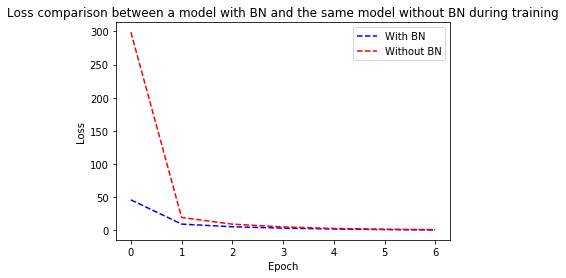

In [13]:
#Graph Plotting for loss comparison
plt.plot(x_axis, loss_BN,    'b--', label='With BN')
plt.plot(x_axis, loss_noBN,  'r--', label='Without BN')
plt.title("Loss comparison between a model with BN and the same model without BN during training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

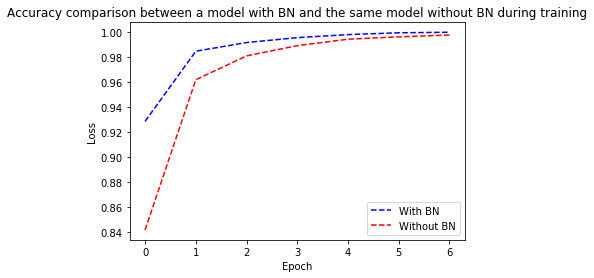

In [14]:
#Graph Plotting for accuracy comparison
plt.plot(x_axis, acc_BN,    'b--', label='With BN')
plt.plot(x_axis, acc_noBN,  'r--', label='Without BN')
plt.title("Accuracy comparison between a model with BN and the same model without BN during training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()